# Media móvil para la emisión de alertas tempranas: el día en el que falló el sistema de facturación electrónica en Costa Rica
Por [Juan M. Fonseca-Solís](https://juanfonsecasolis.github.io/), Sep 2018.

## Resumen

Se plantea determinar el tamaño adecuado de la ventana de análisis de la media móvil, un mecanismo empleado para eliminar (o suavizar) el ruido introducido por las frecuencias altas en los tiempos de respuesta de los servidores web, entre otras señales, y con ello eliminar los picos que podrían producir falsas alertas. Con un tamaño de ventana más pequeño de lo necesario, el procesamiento es inútil, y con un tamaño de ventana excesivo, los picos se detectan tarde. Los paquetes de visualización de datos, como Graphene, no ofrecen una guía de cómo elegir el tamaño adecuado de esta ventana, o bien, lo hacen respecto a la información frecuencial, lo que no aplica para los tiempos de respuesta de los servidores web por no haber necesariamente un comportamiento periódico. En este cuaderno se propone realizar la elección del tamaño de la ventana estudiando el retraso del procesamiento, pues conociendo el desfase de la media móvil, se puede calcular el retardo en el procesamiento como $MT_s$, donde $M$ es el tamaño de la ventana de análisis y $T_s$ es el periodo de muestreo.

## Historia
Cuando los tiempos de respuesta de los sistemas receptores de la factura electrónica superaron los 47 segundos el 1 de setiembre de 2018, unos 156.965 contribuyentes en todos el país experimentaron problemas en la emisión de sus facturas electrónicas, iniciando una ola de quejas en la página de Facebook del Ministerio de Hacienda. El error HTTP retornado por los sistemas fue un 500 (*internal server error*) [4].

![](img/PMaMF.png)

Como consecuencia de este fallo, cundió el pánico entre los contribuyentes; los más informados se respaldaron en el artículo 15º de la resolución Nº DGT-R-48-2016, que permite emitir las facturas de la manera tradicional en casos de caída del sistema para luego ingresar los datos de manera manual [5]. Para enfrentar este problema, las autoridades encargadas de mantener funcionando los sistemas de recepción de facturas realizaron una investigación de los tiempos de respuesta de los servidores web en las últimas horas. La información recopilada permitió aislar el fallo en el sistema de verificación de la firma digital del Banco Central de Costa Rica (BCCR). 

![](img/2013_11_26_10_40_22_zdspb.jpg)
<!--p style="text-align: center;">Ejemplo de una señal de tráfico en un servidor web donde se observan varios picos por encima de 550 ms.</p-->

La técnica de recopilación de bitácoras realizada por el BCCR también es usada en otros sistemas, como los de comercio electrónico, banca en línea, citas médicas y monitoreo de emergencias naturales. Con estas bitácoras es posible emitir alertas automáticas cuando se exceden los máximos definidos por las pruebas de rendimiento [1,3]. Un ejemplo de cómo funciona un control por umbral de alerta se presenta a continuación:

Populating the interactive namespace from numpy and matplotlib


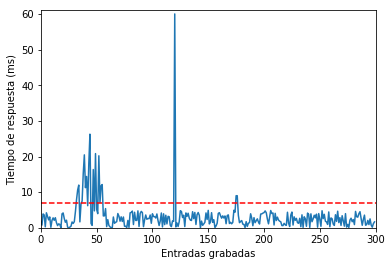

In [2]:
%pylab inline
%matplotlib inline
import numpy as np;
N = 300
x = np.random.rand(N)*5
x[25:65] = np.multiply(x[25:65],6*np.hanning(40))
x[120] = 60
x[175:177] = 9
#figure(figsize=(15, 3), dpi= 150, facecolor='w', edgecolor='k')
plot(x)
xlim([0,N])
ylim([0,max(x)+1])
axhline(y=7, color='r', linestyle='--')
xlabel('Entradas grabadas')
ylabel('Tiempo de respuesta (ms)')
show()

Se observa que los picos en los instantes 40 (25 a 65), 120 y 175 están por encima del umbral de los 7 ms y son reconocidos como eventos indeseados, estos ameritan la emisión de una alerta. Sin embargo, el instante 175 es más bien un *evento transitorio* que no representa una amenaza real pues tarda apenas unos pocos instantes y su amplitud no es tan alta como la del resto de picos. Es necesario, por tanto, filtrar esta clase de eventos que podrían generar falsos positivos.

## Media móvil
Para ignorar los eventos transitorios se suele usar una técnica de "suavizado" de datos llamada la media móvil (MA, por sus siglas en inglés), que se define como sigue [2]:
$$
    y[n] = \frac{1}{M}\sum_{m=0}^{M}{x[n-m]},\quad (1)
$$
donde $M$ es la cantidad de vecinos a considerar en el promedio y $n$ es la muestra analizada actualmente. No se consideran los vecinos posteriores a la muestra actual, pues el procesamiento se realiza de manera causal, es decir, que no se pueden usar muestras que no han sido grabadas. Este método numérico está disponible en la mayoría de paquetes de visualización de datos, entre ellos, Graphite (https://graphite.readthedocs.io/en/latest/functions.html#graphite.render.functions.movingAverage). 

Con $M=10$ vecinos, la ecuación anterior permite obtener la siguiente version suavizada de la señal de ejemplo:

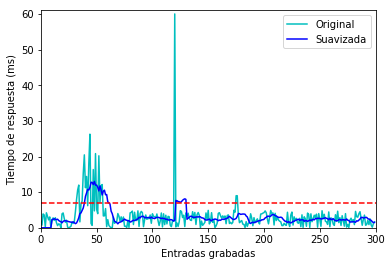

In [4]:
y = [0.0]*N
M=10
for n in range(M,N):
    y[n] = np.sum(x[n-M:n])/M
#figure(figsize=(15, 3), dpi= 150, facecolor='w', edgecolor='k')
plot(x,'c',label='Original')
plot(y,'b',label='Suavizada')
xlim([0,N])
ylim([0,max(x)+1])
axhline(y=7, color='r', linestyle='--')
xlabel('Entradas grabadas')
ylabel('Tiempo de respuesta (ms)')
legend()
show()

Donde se observa que el pico en 175 a sido eliminado y los eventos cerca 40 y 120 se conservan, como es deseado. Sin embargo, una pregunta que surge al usar el MA es saber cuántos vecinos deben elegirse para la ventana de análisis, pues una ventana más grande de lo necesario podría eliminar picos importantes, además de generar alertas tardías (pues hay un retraso temporal); y una ventana demasiado pequeña no lograría eliminar los eventos transitorios.

## Retraso temporal

Una forma de determinar el tamaño de la ventana de análisis es estudiando el retraso temporal que produce la media móvil. Este retraso está determinado por el periodo de muestreo y el *retraso de grupo*. El primer concepto (denotado como $T_s$) se refiere al tiempo transcurrido entre cada par de muestras, y su recíproco ($F_s=1/T_s$), se denomina *frecuencia de muestreo*. El segundo término representa un retraso temporal en el número de muestras entre la señal original y la señal filtrada. En el ejemplo anterior el retraso de grupo es de 10 muestras, correspondientes al tamaño de la ventana de análisis.

El retraso temporal de la media móvil se obtiene multiplicado el periodo de muestreo por el retraso de grupo, es decir, $MT_s$ [2]. Con 10 vecinos en la ventana de análisis y un periodo de muestreo de $T_s=5$ minutos, se obtiene un retraso de grupo de casi una hora (50 minutos). Por otra parte, usando $T_s=1$ minuto, el retraso es de apenas 10 minutos. Es decisión del administrador del sistema determinar cuál retraso de grupo puede tolerar de acuerdo a la urgencia en la emisión de las alertas. Para el caso del fallo en el sistema de facturación del BCCR, este podría haber sido de unos cuantos minutos. 

El retraso de grupo puede mitigarse aumentando el periodo de muestreo, lo que genera más muestras por unidad de tiempo y minimiza el efecto del retraso, pero esto disminuye el espacio disponible para guardar datos en la bitácora. 

### Nota final

El retraso de grupo se determina usando una serie de técnicas del campo del procesamiento digital de señales (DSP, por sus siglas en inglés), que entre otras informaciones, permite encontrar la respuesta en frecuencia y fase. Como parte del campo de estudio de esta disciplina, también se estudian alternativas a la media móvil que permiten realizar filtrados con un desfase menos perjudicial.

## Referencias
1. Brian Jackson. How to Effectively Monitor and Scale for Website Traffic. KeyCDN. 10 de enero de 2017. URL: https://www.keycdn.com/blog/scale-website-traffic/ (última vez consultado el 16 de setiembre de 2018)
2. John G. Proakis y Dimitris K. Manolakis. Digital Signal Processing (4 edición). Prentice-Hall, Inc., Upper Saddle River, NJ, USA. 2006
3. Derek Kraan. Why is my site slow if New Relic says it's fast? Request Queueing. URL: https://img.springe.st/2013_11_26_10_40_22_zdspb.jpg (última vez consultado el 20 de setiembre de 2018)
4. Carlos Cordero. Sistema de factura electrónica falló el día que recibía a nuevo grupo de contribuyentes. La República, tecnología. URL: https://www.elfinancierocr.com/tecnologia/sistema-de-factura-electronica-fallo-el-dia-que/OQ42RGIS2NFPHD2UDAGI66KNQM/story/ (última vez consultado el 23 de setiembre de 2018)
5. Ministerio de Hacienda, Dirección General de Tributación. Comprobantes electrónicos, resolución Nº DGT-R-48-2016. Gobierno de Costa Rica. URL: https://tribunet.hacienda.go.cr/docs/esquemas/2016/v4/Resolucion%20Comprobantes%20Electronicos%20%20DGT-R-48-2016.pdf (última vez consultado el 24 de setiembre de 2018)

---
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="img/80x15.png" /></a><p style="text-align: center;"> Esta obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">licencia Creative Commons Atribución 4.0 Internacional</a>. El sitio <a href="https://juanfonsecasolis.github.io/">juanfonsecasolis.github.io</a> es un blog costarricence dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar la fuente puede usar Bibtex:</p>
```
@online{Fonseca2018,
  author = {Juan M. Fonseca-Solís},
  title = {Media móvil para la emisión de alertas tempranas: el día en el que falló el sistema de facturación electrónica en Costa Rica},
  year = 2018,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.suavizadoTraficoServidorWeb.html},
  urldate = {}
}
```

<!-- Mobile design -->
<meta name="viewport" content="width=device-width, initial-scale=1">

<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-144706135-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-144706135-1');
</script>

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.suavizadoTraficoServidorWeb.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 2; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="//https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>